In [1]:
import pandas as pd
import pickle
import numpy as np
import yfinance as yf
import ta
import os
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm_notebook as tqdm
from IPython.core.interactiveshell import InteractiveShell

np.random.seed(42)

In [2]:
df = yf.download(tickers= "WMT", start = "2000-01-01", end= "2025-09-19",multi_level_index = False, auto_adjust=False)
df.head()

[*********************100%***********************]  1 of 1 completed


,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2000-01-03,14.239624,22.270832,23.000000,21.833332,22.791668,25109700
2000-01-04,13.706800,21.437500,21.937500,21.395832,21.833332,20235300
2000-01-05,13.427070,21.000000,21.458332,20.729168,21.291668,21056100
2000-01-06,13.573599,21.229168,21.520832,20.895832,21.000000,19633500
2000-01-07,14.599280,22.833332,22.979168,21.500000,21.500000,23930700


In [3]:
import pandas as pd
import numpy as np
import ta

# ===============================
# Manual Indicator Implementations
# ===============================

# Weighted Moving Average (helper for HMA)
def WMA(series, window):
    weights = np.arange(1, window+1)
    return series.rolling(window).apply(lambda x: np.dot(x, weights)/weights.sum(), raw=True)

# Hull Moving Average (HMA)
def HMA(series, window):
    if window < 2:
        return series
    half_wma = WMA(series, window//2)
    full_wma = WMA(series, window)
    diff = 2 * half_wma - full_wma
    return WMA(diff, int(np.sqrt(window)))

# Triple Exponential Moving Average (TEMA)
def TEMA(series, window):
    ema1 = series.ewm(span=window, adjust=False).mean()
    ema2 = ema1.ewm(span=window, adjust=False).mean()
    ema3 = ema2.ewm(span=window, adjust=False).mean()
    return 3 * (ema1 - ema2) + ema3

# Chande Momentum Oscillator (CMO)
def CMO(series, window=14):
    diff = series.diff()
    pos = diff.clip(lower=0)
    neg = -diff.clip(upper=0)
    sum_pos = pos.rolling(window=window).sum()
    sum_neg = neg.rolling(window=window).sum()
    return 100 * (sum_pos - sum_neg) / (sum_pos + sum_neg)

# Percentage Price Oscillator (PPO)
def PPO(series, fast=12, slow=26, signal=9):
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()
    ppo = (ema_fast - ema_slow) / ema_slow * 100
    ppo_signal = ppo.ewm(span=signal, adjust=False).mean()
    ppo_hist = ppo - ppo_signal
    return ppo, ppo_signal, ppo_hist

# Parabolic SAR (PSAR)
def PSAR(high, low, step=0.02, max_step=0.2):
    psar = high.copy()
    psar[:] = np.nan

    uptrend = True
    af = step
    ep = low.iloc[0]
    psar.iloc[0] = low.iloc[0]

    for i in range(1, len(high)):
        prev_psar = psar.iloc[i-1]
        psar.iloc[i] = prev_psar + af * (ep - prev_psar)

        if uptrend:
            if low.iloc[i] < psar.iloc[i]:
                uptrend = False
                psar.iloc[i] = ep
                ep = low.iloc[i]
                af = step
            else:
                if high.iloc[i] > ep:
                    ep = high.iloc[i]
                    af = min(af + step, max_step)
        else:
            if high.iloc[i] > psar.iloc[i]:
                uptrend = True
                psar.iloc[i] = ep
                ep = high.iloc[i]
                af = step
            else:
                if low.iloc[i] < ep:
                    ep = low.iloc[i]
                    af = min(af + step, max_step)
    return psar

# ===============================
# Master Function to Add All Indicators
# ===============================
def add_indicators(df):
    for window in range(6, 21):  # 6 to 20 inclusive

        # --- Momentum Indicators ---
        df[f'RSI_{window}'] = ta.momentum.RSIIndicator(df['Close'], window=window).rsi()
        df[f'Williams_%R_{window}'] = ta.momentum.WilliamsRIndicator(df['High'], df['Low'], df['Close'], lbp=window).williams_r()
        df[f'ROC_{window}'] = ta.momentum.ROCIndicator(df['Close'], window=window).roc()
        df[f'CMO_{window}'] = CMO(df['Close'], window=window)

        # --- Trend Indicators ---
        df[f'SMA_{window}'] = ta.trend.SMAIndicator(df['Close'], window=window).sma_indicator()
        df[f'EMA_{window}'] = ta.trend.EMAIndicator(df['Close'], window=window).ema_indicator()
        df[f'WMA_{window}'] = WMA(df['Close'], window)
        df[f'HMA_{window}'] = HMA(df['Close'], window)
        df[f'TEMA_{window}'] = TEMA(df['Close'], window)

        # --- MACD (scaled with window) ---
        macd = ta.trend.MACD(df['Close'],
                             window_slow=2*window,
                             window_fast=window,
                             window_sign=max(3, window//2))
        df[f'MACD_{window}'] = macd.macd()
        df[f'MACD_Signal_{window}'] = macd.macd_signal()
        df[f'MACD_Hist_{window}'] = macd.macd_diff()

        # --- PPO ---
        ppo, ppo_sig, ppo_hist = PPO(df['Close'],
                                     fast=window,
                                     slow=2*window,
                                     signal=max(3, window//2))
        df[f'PPO_{window}'] = ppo
        df[f'PPO_Signal_{window}'] = ppo_sig
        df[f'PPO_Hist_{window}'] = ppo_hist

        # --- CCI ---
        df[f'CCI_{window}'] = ta.trend.CCIIndicator(df['High'], df['Low'], df['Close'], window=window).cci()

        # --- CMFI ---
        df[f'CMFI_{window}'] = ta.volume.ChaikinMoneyFlowIndicator(
            df['High'], df['Low'], df['Close'], df['Volume'], window=window
        ).chaikin_money_flow()

        # --- DMI (ADX, +DI, -DI) ---
        dmi = ta.trend.ADXIndicator(df['High'], df['Low'], df['Close'], window=window)
        df[f'ADX_{window}'] = dmi.adx()
        df[f'+DI_{window}'] = dmi.adx_pos()
        df[f'-DI_{window}'] = dmi.adx_neg()

        # --- Parabolic SAR ---
        df[f'Parabolic_SAR_{window}'] = PSAR(df['High'], df['Low'])

    return df

df = add_indicators(df)
df.head()

,Adj Close,Close,High,Low,Open,Volume,RSI_6,Williams_%R_6,ROC_6,CMO_6,...,MACD_Hist_20,PPO_20,PPO_Signal_20,PPO_Hist_20,CCI_20,CMFI_20,ADX_20,+DI_20,-DI_20,Parabolic_SAR_20
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,14.239624,22.270832,23.000000,21.833332,22.791668,25109700,NaN,NaN,NaN,NaN,...,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.0,0.0,0.0,21.833332
2000-01-04,13.706800,21.437500,21.937500,21.395832,21.833332,20235300,NaN,NaN,NaN,NaN,...,NaN,-0.174153,-0.031664,-0.142489,NaN,NaN,0.0,0.0,0.0,21.833332
2000-01-05,13.427070,21.000000,21.458332,20.729168,21.291668,21056100,NaN,NaN,NaN,NaN,...,NaN,-0.415778,-0.101503,-0.314275,NaN,NaN,0.0,0.0,0.0,21.824582
2000-01-06,13.573599,21.229168,21.520832,20.895832,21.000000,19633500,NaN,NaN,NaN,NaN,...,NaN,-0.574558,-0.187513,-0.387045,NaN,NaN,0.0,0.0,0.0,21.780765
2000-01-07,14.599280,22.833332,22.979168,21.500000,21.500000,23930700,NaN,NaN,NaN,NaN,...,NaN,-0.370367,-0.220759,-0.149607,NaN,NaN,0.0,0.0,0.0,20.729168


In [4]:
def add_labels(df, window_size=11):
    closes = df['Close'].values
    labels = ["0"] * len(df)  # default HOLD

    half = window_size // 2
    for t in range(half, len(df) - half):
        window = closes[t - half : t + half + 1]
        min_idx = window.argmin()
        max_idx = window.argmax()
        middle_idx = half  # center of the window

        if max_idx == middle_idx:
            labels[t] = "1"
        elif min_idx == middle_idx:
            labels[t] = "2"
        else:
            labels[t] = "0"

    df['Label'] = labels
    return df

df = add_labels(df, window_size=11)
df.head(10)

,Adj Close,Close,High,Low,Open,Volume,RSI_6,Williams_%R_6,ROC_6,CMO_6,...,PPO_20,PPO_Signal_20,PPO_Hist_20,CCI_20,CMFI_20,ADX_20,+DI_20,-DI_20,Parabolic_SAR_20,Label
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,14.239624,22.270832,23.000000,21.833332,22.791668,25109700,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,NaN,NaN,0.0,0.0,0.0,21.833332,0
2000-01-04,13.706800,21.437500,21.937500,21.395832,21.833332,20235300,NaN,NaN,NaN,NaN,...,-0.174153,-0.031664,-0.142489,NaN,NaN,0.0,0.0,0.0,21.833332,0
2000-01-05,13.427070,21.000000,21.458332,20.729168,21.291668,21056100,NaN,NaN,NaN,NaN,...,-0.415778,-0.101503,-0.314275,NaN,NaN,0.0,0.0,0.0,21.824582,0
2000-01-06,13.573599,21.229168,21.520832,20.895832,21.000000,19633500,NaN,NaN,NaN,NaN,...,-0.574558,-0.187513,-0.387045,NaN,NaN,0.0,0.0,0.0,21.780765,0
2000-01-07,14.599280,22.833332,22.979168,21.500000,21.500000,23930700,NaN,NaN,NaN,NaN,...,-0.370367,-0.220759,-0.149607,NaN,NaN,0.0,0.0,0.0,20.729168,0
2000-01-10,14.332865,22.416668,22.500000,21.875000,22.416668,20142900,58.260867,-25.688032,NaN,NaN,...,-0.280883,-0.231691,-0.049192,NaN,NaN,0.0,0.0,0.0,20.774168,0
2000-01-11,14.119734,22.083332,22.583332,21.875000,22.354168,14829900,50.408078,-39.814928,-0.841908,-4.864868,...,-0.272646,-0.239137,-0.033509,NaN,NaN,0.0,0.0,0.0,20.818268,0
2000-01-12,13.866648,21.687500,22.250000,21.687500,22.062500,12255000,42.286210,-57.407464,1.166181,7.317079,...,-0.347568,-0.258852,-0.088716,NaN,NaN,0.0,0.0,0.0,20.861486,0
2000-01-13,13.879970,21.708332,22.041668,21.666668,22.000000,15063000,42.867564,-61.000048,3.373010,23.611099,...,-0.406205,-0.285643,-0.120561,NaN,NaN,0.0,0.0,0.0,20.903840,0


In [5]:
df = df.dropna().reset_index(drop=True)
df.head()

,Adj Close,Close,High,Low,Open,Volume,RSI_6,Williams_%R_6,ROC_6,CMO_6,...,PPO_20,PPO_Signal_20,PPO_Hist_20,CCI_20,CMFI_20,ADX_20,+DI_20,-DI_20,Parabolic_SAR_20,Label
0,10.163549,15.895833,15.979167,15.291667,15.416667,23183700,40.442366,-70.796464,-9.382431,-64.227680,...,-6.347171,-6.383810,0.036639,-60.410351,-0.070825,30.640346,15.868043,30.904164,15.243504,0
1,10.176865,15.916667,16.270832,15.437500,15.666667,29955000,41.014445,-48.484767,-5.445536,-48.888829,...,-6.294965,-6.367657,0.072691,-44.793866,-0.086045,30.506291,16.669818,29.609034,15.344597,0
2,10.989910,17.166668,17.312500,15.520833,15.812500,44010000,65.129764,-6.930632,8.278587,61.165048,...,-5.875434,-6.278162,0.402728,53.118713,-0.074881,29.697770,20.262273,27.044055,15.441647,0
3,11.656773,18.208332,18.520832,17.208332,17.437500,59148000,75.248851,-9.677424,13.065960,71.631166,...,-5.199282,-6.082002,0.882719,213.263835,0.012272,28.271989,24.709157,25.300336,15.534814,0
4,11.896842,18.583332,18.750000,18.041668,18.187500,37911900,78.006086,-4.819314,13.920810,73.154336,...,-4.491665,-5.792850,1.301184,214.591857,0.119847,26.912868,24.971227,24.432931,15.713975,0


In [6]:
df.isna().sum()

,0
Adj Close,0
Close,0
High,0
Low,0
Open,0
...,...
ADX_20,0
+DI_20,0
-DI_20,0
Parabolic_SAR_20,0


Split data into Training, Validation and Test

In [7]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from collections import Counter

list_features = list(df.loc[:, 'Open':'Parabolic_SAR_20'].columns)
print('Total number of features', len(list_features))
x_train, x_test, y_train, y_test = train_test_split(df.loc[:, 'Open':'Parabolic_SAR_20'].values, df['Label'].values, train_size=0.8,
                                                    test_size=0.2, random_state=2, shuffle=True, stratify=df['Label'].values)

if 0.7*x_train.shape[0] < 2500:
    train_split = 0.8
else:
    train_split = 0.7

print('train_split =',train_split)
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, train_size=train_split, test_size=1-train_split,
                                                random_state=2, shuffle=True, stratify=y_train)
mm_scaler = MinMaxScaler(feature_range=(0, 1))
x_train = mm_scaler.fit_transform(x_train)
x_cv = mm_scaler.transform(x_cv)
x_test = mm_scaler.transform(x_test)

x_main = x_train.copy()
print("Shape of x, y train/cv/test {} {} {} {} {} {}".format(x_train.shape, y_train.shape, x_cv.shape, y_cv.shape, x_test.shape, y_test.shape))

Total number of features 317
train_split = 0.7
Shape of x, y train/cv/test (3594, 317) (3594,) (1541, 317) (1541,) (1284, 317) (1284,)


Out of total 300+ features select top 'N' features

In [8]:
num_features = 289  # should be a perfect square
selection_method = 'all'
topk = 323 if selection_method == 'all' else num_features
# if train_split >= 0.8:
#     topk = 400
# else:
#     topk = 300

In [9]:
%%time
from operator import itemgetter
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

if selection_method == 'anova' or selection_method == 'all':
    select_k_best = SelectKBest(f_classif, k=topk)
    if selection_method != 'all':
        x_train = select_k_best.fit_transform(x_main, y_train)
        x_cv = select_k_best.transform(x_cv)
        x_test = select_k_best.transform(x_test)
    else:
        select_k_best.fit(x_main, y_train)

    selected_features_anova = itemgetter(*select_k_best.get_support(indices=True))(list_features)
    print(selected_features_anova)
    print(select_k_best.get_support(indices=True))
    print("****************************************")

if selection_method == 'mutual_info' or selection_method == 'all':
    select_k_best = SelectKBest(mutual_info_classif, k=topk)
    if selection_method != 'all':
        x_train = select_k_best.fit_transform(x_main, y_train)
        x_cv = select_k_best.transform(x_cv)
        x_test = select_k_best.transform(x_test)
    else:
        select_k_best.fit(x_main, y_train)

    selected_features_mic = itemgetter(*select_k_best.get_support(indices=True))(list_features)
    print(len(selected_features_mic), selected_features_mic)
    print(select_k_best.get_support(indices=True))

('Open', 'Volume', 'RSI_6', 'Williams_%R_6', 'ROC_6', 'CMO_6', 'SMA_6', 'EMA_6', 'WMA_6', 'HMA_6', 'TEMA_6', 'MACD_6', 'MACD_Signal_6', 'MACD_Hist_6', 'PPO_6', 'PPO_Signal_6', 'PPO_Hist_6', 'CCI_6', 'CMFI_6', 'ADX_6', '+DI_6', '-DI_6', 'Parabolic_SAR_6', 'RSI_7', 'Williams_%R_7', 'ROC_7', 'CMO_7', 'SMA_7', 'EMA_7', 'WMA_7', 'HMA_7', 'TEMA_7', 'MACD_7', 'MACD_Signal_7', 'MACD_Hist_7', 'PPO_7', 'PPO_Signal_7', 'PPO_Hist_7', 'CCI_7', 'CMFI_7', 'ADX_7', '+DI_7', '-DI_7', 'Parabolic_SAR_7', 'RSI_8', 'Williams_%R_8', 'ROC_8', 'CMO_8', 'SMA_8', 'EMA_8', 'WMA_8', 'HMA_8', 'TEMA_8', 'MACD_8', 'MACD_Signal_8', 'MACD_Hist_8', 'PPO_8', 'PPO_Signal_8', 'PPO_Hist_8', 'CCI_8', 'CMFI_8', 'ADX_8', '+DI_8', '-DI_8', 'Parabolic_SAR_8', 'RSI_9', 'Williams_%R_9', 'ROC_9', 'CMO_9', 'SMA_9', 'EMA_9', 'WMA_9', 'HMA_9', 'TEMA_9', 'MACD_9', 'MACD_Signal_9', 'MACD_Hist_9', 'PPO_9', 'PPO_Signal_9', 'PPO_Hist_9', 'CCI_9', 'CMFI_9', 'ADX_9', '+DI_9', '-DI_9', 'Parabolic_SAR_9', 'RSI_10', 'Williams_%R_10', 'ROC_10',

In [10]:
if selection_method == 'all':
    common = list(set(selected_features_anova).intersection(selected_features_mic))
    print("common selected featues", len(common), common)
    if len(common) < num_features:
        raise Exception('number of common features found {} < {} required features. Increase "topk variable"'.format(len(common), num_features))
    feat_idx = []
    for c in common:
        feat_idx.append(list_features.index(c))
    feat_idx = sorted(feat_idx[0:289])
    print(feat_idx)

common selected featues 317 ['TEMA_7', 'HMA_11', 'WMA_14', 'Williams_%R_6', 'PPO_7', 'RSI_17', 'TEMA_6', 'MACD_Hist_14', 'CMO_18', 'EMA_9', 'RSI_16', 'MACD_Hist_15', 'Williams_%R_11', 'PPO_Signal_20', 'ADX_17', 'CCI_11', 'EMA_15', 'CMO_6', 'EMA_16', 'PPO_Hist_7', 'Williams_%R_14', '+DI_16', 'ADX_18', '+DI_7', '+DI_11', 'PPO_Signal_14', 'MACD_11', 'Parabolic_SAR_11', 'MACD_6', 'PPO_Signal_15', 'CMO_10', 'WMA_19', 'CCI_14', 'Parabolic_SAR_18', 'SMA_15', 'SMA_6', 'EMA_14', '-DI_7', 'Williams_%R_18', 'PPO_Hist_10', 'RSI_20', 'CCI_8', 'MACD_12', 'HMA_13', 'PPO_15', 'ADX_7', 'MACD_17', 'MACD_10', 'PPO_Signal_16', 'PPO_Signal_17', 'CMFI_20', 'Volume', 'PPO_Hist_6', 'MACD_Hist_11', 'PPO_10', 'Parabolic_SAR_13', 'MACD_19', 'HMA_8', 'SMA_13', 'MACD_Signal_12', 'RSI_19', 'PPO_Signal_13', 'CCI_10', '-DI_16', 'MACD_Hist_10', 'PPO_Signal_6', 'MACD_Hist_7', 'EMA_6', 'ROC_9', 'MACD_20', 'PPO_19', 'RSI_18', 'PPO_Hist_8', 'CCI_19', 'PPO_Hist_9', 'EMA_20', 'CCI_9', 'CMFI_19', 'Open', 'RSI_6', 'CMO_13', '

In [11]:
if selection_method == 'all':
    x_train = x_train[:, feat_idx]
    x_cv = x_cv[:, feat_idx]
    x_test = x_test[:, feat_idx]

print("Shape of x, y train/cv/test {} {} {} {} {} {}".format(x_train.shape,
                                                             y_train.shape, x_cv.shape, y_cv.shape, x_test.shape, y_test.shape))

Shape of x, y train/cv/test (3594, 289) (3594,) (1541, 289) (1541,) (1284, 289) (1284,)


In [12]:
_labels, _counts = np.unique(y_train, return_counts=True)
print("percentage of class 0 = {}, class 1 = {}".format(_counts[0]/len(y_train) * 100, _counts[1]/len(y_train) * 100))

percentage of class 0 = 87.72954924874792, class 1 = 6.260434056761269


In [13]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

def get_sample_weights(y):
    """
    calculate the sample weights based on class weights. Used for models with
    imbalanced data and one hot encoding prediction.

    params:
        y: class labels as integers
    """

    y = y.astype(int)  # compute_class_weight needs int labels
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)

    print("real class weights are {}".format(class_weights), np.unique(y))
    print("value_counts", np.unique(y, return_counts=True))
    sample_weights = y.copy().astype(float)
    for i in np.unique(y):
        sample_weights[sample_weights == i] = class_weights[i]  # if i == 2 else 0.8 * class_weights[i]
        # sample_weights = np.where(sample_weights == i, class_weights[int(i)], y_)

    return sample_weights

def reshape_as_image(x, img_width, img_height):
    x_temp = np.zeros((len(x), img_height, img_width))
    for i in range(x.shape[0]):
        # print(type(x), type(x_temp), x.shape)
        x_temp[i] = np.reshape(x[i], (img_height, img_width))

    return x_temp

def f1_weighted(y_true, y_pred):
    y_true_class = tf.math.argmax(y_true, axis=1, output_type=tf.dtypes.int32)
    y_pred_class = tf.math.argmax(y_pred, axis=1, output_type=tf.dtypes.int32)
    conf_mat = tf.math.confusion_matrix(y_true_class, y_pred_class)  # can use conf_mat[0, :], tf.slice()
    # precision = TP/TP+FP, recall = TP/TP+FN
    rows, cols = conf_mat.get_shape()
    size = y_true_class.get_shape()[0]
    precision = tf.constant([0, 0, 0])  # change this to use rows/cols as size
    recall = tf.constant([0, 0, 0])
    class_counts = tf.constant([0, 0, 0])

    def get_precision(i, conf_mat):
        print("prec check", conf_mat, conf_mat[i, i], tf.reduce_sum(conf_mat[:, i]))
        precision[i].assign(conf_mat[i, i] / tf.reduce_sum(conf_mat[:, i]))
        recall[i].assign(conf_mat[i, i] / tf.reduce_sum(conf_mat[i, :]))
        tf.add(i, 1)
        return i, conf_mat, precision, recall

    def tf_count(i):
        elements_equal_to_value = tf.equal(y_true_class, i)
        as_ints = tf.cast(elements_equal_to_value, tf.int32)
        count = tf.reduce_sum(as_ints)
        class_counts[i].assign(count)
        tf.add(i, 1)
        return count

    def condition(i, conf_mat):
        return tf.less(i, 3)

    i = tf.constant(3)
    i, conf_mat = tf.while_loop(condition, get_precision, [i, conf_mat])

    i = tf.constant(3)
    c = lambda i: tf.less(i, 3)
    b = tf_count(i)
    tf.while_loop(c, b, [i])

    weights = tf.math.divide(class_counts, size)
    numerators = tf.math.multiply(tf.math.multiply(precision, recall), tf.constant(2))
    denominators = tf.math.add(precision, recall)
    f1s = tf.math.divide(numerators, denominators)
    weighted_f1 = tf.reduce_sum(f.math.multiply(f1s, weights))
    return weighted_f1

def f1_metric(y_true, y_pred):
    """
    this calculates precision & recall
    """

    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))  # mistake: y_pred of 0.3 is also considered 1
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    # y_true_class = tf.math.argmax(y_true, axis=1, output_type=tf.dtypes.int32)
    # y_pred_class = tf.math.argmax(y_pred, axis=1, output_type=tf.dtypes.int32)
    # conf_mat = tf.math.confusion_matrix(y_true_class, y_pred_class)
    # tf.Print(conf_mat, [conf_mat], "confusion_matrix")

    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

get_custom_objects().update({"f1_metric": f1_metric, "f1_weighted": f1_weighted})

In [14]:
sample_weights = get_sample_weights(y_train)
print("Test sample_weights")
rand_idx = np.random.randint(0, 1000, 30)
print(y_train[rand_idx])
print(sample_weights[rand_idx])

real class weights are [0.3799556  5.32444444 5.5462963 ] [0 1 2]
value_counts (array([0, 1, 2]), array([3153,  225,  216]))
Test sample_weights
['0' '0' '0' '1' '0' '0' '2' '0' '0' '0' '0' '0' '0' '0' '2' '0' '0' '0'
 '0' '1' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0']
[0.3799556  0.3799556  0.3799556  5.32444444 0.3799556  0.3799556
 5.5462963  0.3799556  0.3799556  0.3799556  0.3799556  0.3799556
 0.3799556  0.3799556  5.5462963  0.3799556  0.3799556  0.3799556
 0.3799556  5.32444444 0.3799556  0.3799556  0.3799556  0.3799556
 0.3799556  0.3799556  0.3799556  0.3799556  0.3799556  0.3799556 ]


In [15]:
one_hot_enc = OneHotEncoder(sparse_output=False, categories='auto')  # , categories='auto'
y_train = one_hot_enc.fit_transform(y_train.reshape(-1, 1))
print("y_train",y_train.shape)
y_cv = one_hot_enc.transform(y_cv.reshape(-1, 1))
y_test = one_hot_enc.transform(y_test.reshape(-1, 1))

y_train (3594, 3)


In [16]:
dim = int(np.sqrt(num_features))
x_train = reshape_as_image(x_train, dim, dim)
x_cv = reshape_as_image(x_cv, dim, dim)
x_test = reshape_as_image(x_test, dim, dim)
# adding a 1-dim for channels (3)
x_train = np.stack((x_train,) * 3, axis=-1)
x_test = np.stack((x_test,) * 3, axis=-1)
x_cv = np.stack((x_cv,) * 3, axis=-1)
print("final shape of x, y train/test {} {} {} {}".format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))

final shape of x, y train/test (3594, 17, 17, 3) (3594, 3) (1284, 17, 17, 3) (1284, 3)


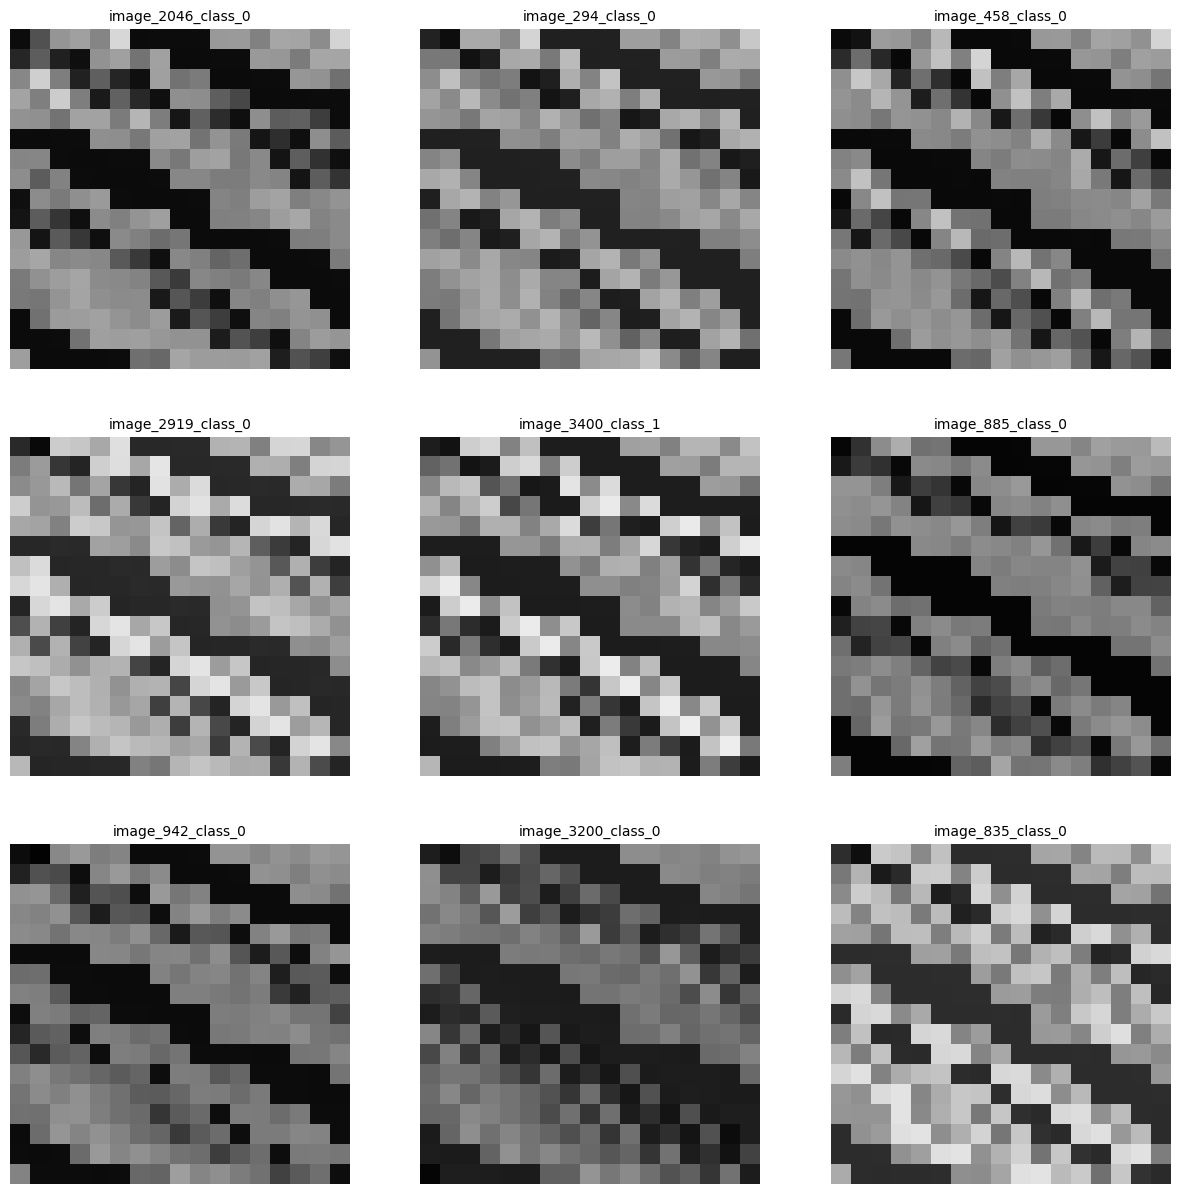

In [17]:
from matplotlib import pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(15, 15))
columns = rows = 3
for i in range(1, columns*rows +1):
    index = np.random.randint(len(x_train))
    img = x_train[index]
    fig.add_subplot(rows, columns, i)
    plt.axis("off")
    plt.title('image_'+str(index)+'_class_'+str(np.argmax(y_train[index])), fontsize=10)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.imshow(img)
plt.show()

In [18]:
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, Callback
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2, l1, l1_l2
from tensorflow.keras.initializers import RandomUniform, RandomNormal
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers

params = {'batch_size': 80, 'conv2d_layers': {'conv2d_do_1': 0.2, 'conv2d_filters_1': 32, 'conv2d_kernel_size_1': 3, 'conv2d_mp_1': 0,
                                               'conv2d_strides_1': 1, 'kernel_regularizer_1': 0.0, 'conv2d_do_2': 0.3,
                                               'conv2d_filters_2': 64, 'conv2d_kernel_size_2': 3, 'conv2d_mp_2': 2, 'conv2d_strides_2': 1,
                                               'kernel_regularizer_2': 0.0, 'layers': 'two'},
           'dense_layers': {'dense_do_1': 0.3, 'dense_nodes_1': 128, 'kernel_regularizer_1': 0.0, 'layers': 'one'},
           'epochs': 3000, 'lr': 0.001, 'optimizer': 'adam'}


In [19]:
from functools import *
from sklearn.metrics import f1_score
from tensorflow.keras.metrics import AUC

def f1_custom(y_true, y_pred):
    y_t = np.argmax(y_true, axis=1)
    y_p = np.argmax(y_pred, axis=1)
    f1_score(y_t, y_p, labels=None, average='weighted', sample_weight=None, zero_division='warn')

def create_model_cnn(params):
    model = Sequential()

    print("Training with params {}".format(params))

    conv2d_layer1 = Conv2D(params["conv2d_layers"]["conv2d_filters_1"],
                           params["conv2d_layers"]["conv2d_kernel_size_1"],
                           strides=params["conv2d_layers"]["conv2d_strides_1"],
                           kernel_regularizer=regularizers.l2(params["conv2d_layers"]["kernel_regularizer_1"]),
                           padding='same',activation="relu", use_bias=True,
                           kernel_initializer='glorot_uniform',
                           input_shape=(x_train[0].shape[0],
                                        x_train[0].shape[1], x_train[0].shape[2]))
    model.add(conv2d_layer1)
    if params["conv2d_layers"]['conv2d_mp_1'] > 1:
        model.add(MaxPool2D(pool_size=params["conv2d_layers"]['conv2d_mp_1']))

    model.add(Dropout(params['conv2d_layers']['conv2d_do_1']))
    if params["conv2d_layers"]['layers'] == 'two':
        conv2d_layer2 = Conv2D(params["conv2d_layers"]["conv2d_filters_2"],
                               params["conv2d_layers"]["conv2d_kernel_size_2"],
                               strides=params["conv2d_layers"]["conv2d_strides_2"],
                               kernel_regularizer=regularizers.l2(params["conv2d_layers"]["kernel_regularizer_2"]),
                               padding='same',activation="relu", use_bias=True,
                               kernel_initializer='glorot_uniform')
        model.add(conv2d_layer2)

        if params["conv2d_layers"]['conv2d_mp_2'] > 1:
            model.add(MaxPool2D(pool_size=params["conv2d_layers"]['conv2d_mp_2']))

        model.add(Dropout(params['conv2d_layers']['conv2d_do_2']))

    model.add(Flatten())

    model.add(Dense(params['dense_layers']["dense_nodes_1"], activation='relu'))
    model.add(Dropout(params['dense_layers']['dense_do_1']))

    if params['dense_layers']["layers"] == 'two':
        model.add(Dense(params['dense_layers']["dense_nodes_2"], activation='relu',
                        kernel_regularizer=params['dense_layers']["kernel_regularizer_1"]))
        model.add(Dropout(params['dense_layers']['dense_do_2']))

    model.add(Dense(3, activation='softmax'))

    if params["optimizer"] == 'rmsprop':
        optimizer = optimizers.RMSprop(lr=params["lr"])
    elif params["optimizer"] == 'sgd':
        optimizer = optimizers.SGD(lr=params["lr"], decay=1e-6, momentum=0.9, nesterov=True)
    elif params["optimizer"] == 'adam':
        optimizer = optimizers.Adam(learning_rate=params["lr"], beta_1=0.9, beta_2=0.999, amsgrad=False)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', f1_metric])

    return model
def create_model_cnn(params):
    model = Sequential()

    print("Training with params {}".format(params))

    conv2d_layer1 = Conv2D(params["conv2d_layers"]["conv2d_filters_1"],
                           params["conv2d_layers"]["conv2d_kernel_size_1"],
                           strides=params["conv2d_layers"]["conv2d_strides_1"],
                           kernel_regularizer=regularizers.l2(params["conv2d_layers"]["kernel_regularizer_1"]),
                           padding='same',activation="relu", use_bias=True,
                           kernel_initializer='glorot_uniform',
                           input_shape=(x_train[0].shape[0],
                                        x_train[0].shape[1], x_train[0].shape[2]))
    model.add(conv2d_layer1)
    if params["conv2d_layers"]['conv2d_mp_1'] > 1:
        model.add(MaxPool2D(pool_size=params["conv2d_layers"]['conv2d_mp_1']))
    model.add(Dropout(params['conv2d_layers']['conv2d_do_1']))
    if params["conv2d_layers"]['layers'] == 'two':
        conv2d_layer2 = Conv2D(params["conv2d_layers"]["conv2d_filters_2"],
                               params["conv2d_layers"]["conv2d_kernel_size_2"],
                               strides=params["conv2d_layers"]["conv2d_strides_2"],
                               kernel_regularizer=regularizers.l2(params["conv2d_layers"]["kernel_regularizer_2"]),
                               padding='same',activation="relu", use_bias=True,
                               kernel_initializer='glorot_uniform')
        model.add(conv2d_layer2)
        if params["conv2d_layers"]['conv2d_mp_2'] > 1:
            model.add(MaxPool2D(pool_size=params["conv2d_layers"]['conv2d_mp_2']))
        model.add(Dropout(params['conv2d_layers']['conv2d_do_2']))

    model.add(Flatten())

    model.add(Dense(params['dense_layers']["dense_nodes_1"], activation='relu'))
    model.add(Dropout(params['dense_layers']['dense_do_1']))

    if params['dense_layers']["layers"] == 'two':
        model.add(Dense(params['dense_layers']["dense_nodes_2"], activation='relu',
                        kernel_regularizer=params['dense_layers']["kernel_regularizer_1"]))
        model.add(Dropout(params['dense_layers']['dense_do_2']))

    model.add(Dense(3, activation='softmax'))
    if params["optimizer"] == 'rmsprop':
        optimizer = optimizers.RMSprop(lr=params["lr"])
    elif params["optimizer"] == 'sgd':
        optimizer = optimizers.SGD(lr=params["lr"], decay=1e-6, momentum=0.9, nesterov=True)
    elif params["optimizer"] == 'adam':
        optimizer = optimizers.Adam(learning_rate=params["lr"], beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', f1_metric])
    # from keras.utils.vis_utils import plot_model use this too for diagram with plot
    # model.summary(print_fn=lambda x: print(x + '\n'))
    return model

def check_baseline(pred, y_test):
    print("size of test set", len(y_test))
    e = np.equal(pred, y_test)
    print("TP class counts", np.unique(y_test[e], return_counts=True))
    print("True class counts", np.unique(y_test, return_counts=True))
    print("Pred class counts", np.unique(pred, return_counts=True))
    holds = np.unique(y_test, return_counts=True)[1][2]  # number 'hold' predictions
    print("baseline acc:", (holds/len(y_test)*100))

Training with params {'batch_size': 80, 'conv2d_layers': {'conv2d_do_1': 0.2, 'conv2d_filters_1': 32, 'conv2d_kernel_size_1': 3, 'conv2d_mp_1': 0, 'conv2d_strides_1': 1, 'kernel_regularizer_1': 0.0, 'conv2d_do_2': 0.3, 'conv2d_filters_2': 64, 'conv2d_kernel_size_2': 3, 'conv2d_mp_2': 2, 'conv2d_strides_2': 1, 'kernel_regularizer_2': 0.0, 'layers': 'two'}, 'dense_layers': {'dense_do_1': 0.3, 'dense_nodes_1': 128, 'kernel_regularizer_1': 0.0, 'layers': 'one'}, 'epochs': 3000, 'lr': 0.001, 'optimizer': 'adam'}


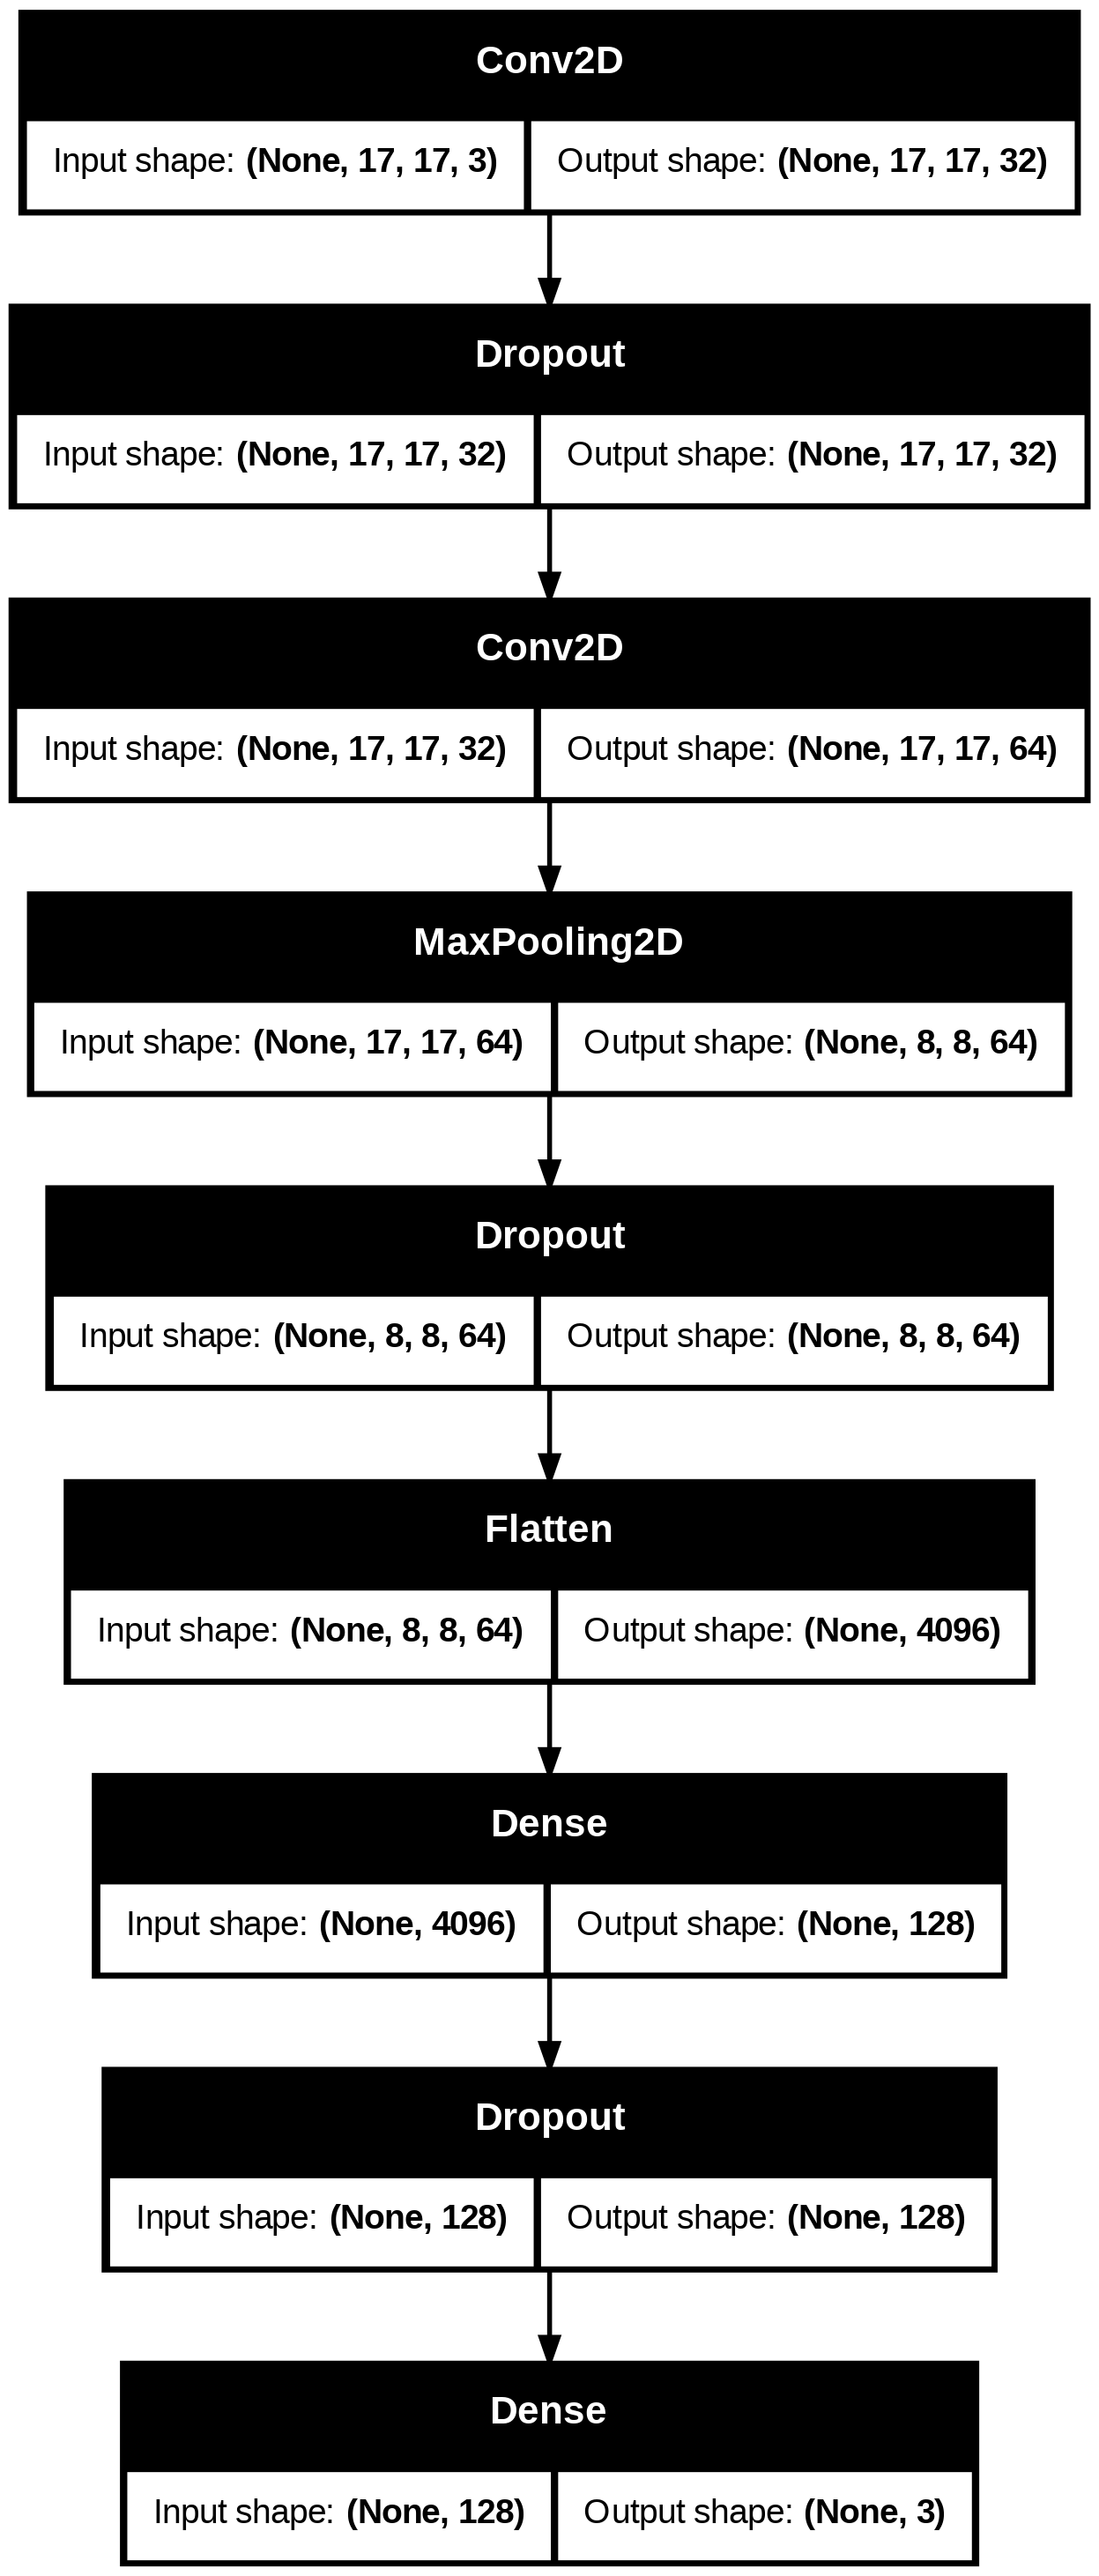

In [20]:
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot, plot_model

model = create_model_cnn(params)
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

# SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [21]:
import os

best_model_path = os.path.join('.', 'best_model_keras.keras')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                   patience=100, min_delta=0.0001)
# csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'log_training_batch.log'), append=True)
rlp = ReduceLROnPlateau(monitor='val_loss', factor=0.02, patience=20, verbose=1, mode='min',
                        min_delta=0.001, cooldown=1, min_lr=0.0001)
mcp = ModelCheckpoint(best_model_path, monitor='val_f1_metric', verbose=1,
                      save_best_only=True, save_weights_only=False, mode='max')  # val_f1_metric

In [22]:
%%time
history = model.fit(x_train, y_train, epochs=50, verbose=1,
                            batch_size=64, shuffle=True,
                            # validation_split=0.3,
                            validation_data=(x_cv, y_cv),
                            callbacks=[mcp, rlp, es]
                            , sample_weight=sample_weights)

Epoch 1/50
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3026 - f1_metric: 0.1590 - loss: 1.0891
Epoch 1: val_f1_metric improved from -inf to 0.15345, saving model to ./best_model_keras.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.3035 - f1_metric: 0.1589 - loss: 1.0847 - val_accuracy: 0.3478 - val_f1_metric: 0.1534 - val_loss: 1.0537 - learning_rate: 0.0010
Epoch 2/50
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3485 - f1_metric: 0.2245 - loss: 0.7817
Epoch 2: val_f1_metric improved from 0.15345 to 0.26477, saving model to ./best_model_keras.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.3499 - f1_metric: 0.2267 - loss: 0.7792 - val_accuracy: 0.3439 - val_f1_metric: 0.2648 - val_loss: 0.9861 - learning_rate: 0.0010
Epoch 3/50
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.3672 - f1_metric: 0.2978 - loss: 0.6805
Epoch 3: val_f1_metric did not improve from 0.26477
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - accuracy: 0.3684 - f1_metric

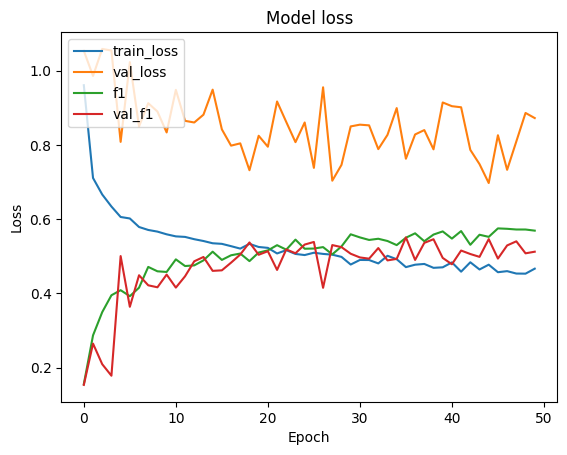

In [23]:
from matplotlib import pyplot as plt
%matplotlib inline
InteractiveShell.ast_node_interactivity = "last"

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['f1_metric'])
plt.plot(history.history['val_f1_metric'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss', 'f1', 'val_f1'], loc='upper left')
plt.show()

In [27]:
from sklearn.metrics import confusion_matrix, roc_auc_score, cohen_kappa_score
import seaborn as sns

model = load_model(best_model_path)
test_res = model.evaluate(x_test, y_test, verbose=0)
print("keras evaluate=", test_res)
pred = model.predict(x_test)
pred_classes = np.argmax(pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
check_baseline(pred_classes, y_test_classes)
conf_mat = confusion_matrix(y_test_classes, pred_classes)
print(conf_mat)
labels = [0,1,2]
# ax = sns.heatmap(conf_mat, xticklabels=labels, yticklabels=labels, annot=True)
# ax.xaxis.set_ticks_position('top')
f1_weighted = f1_score(y_test_classes, pred_classes, labels=None,
         average='weighted', sample_weight=None)
print("F1 score (weighted)", f1_weighted)
print("F1 score (macro)", f1_score(y_test_classes, pred_classes, labels=None,
         average='macro', sample_weight=None))
print("F1 score (micro)", f1_score(y_test_classes, pred_classes, labels=None,
         average='micro', sample_weight=None))  # weighted and micro preferred in case of imbalance
# https://scikit-learn.org/stable/modules/model_evaluation.html#cohen-s-kappa --> supports multiclass; ref: https://stats.stackexchange.com/questions/82162/cohens-kappa-in-plain-english
print("cohen's Kappa", cohen_kappa_score(y_test_classes, pred_classes))


n_classes = conf_mat.shape[0]

precision = []
recall = []
f1 = []

for i in range(n_classes):
    TP = conf_mat[i, i]
    FP = conf_mat[:, i].sum() - TP
    FN = conf_mat[i, :].sum() - TP

    prec = TP / (TP + FP) if (TP + FP) > 0 else 0
    rec = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0

    precision.append(np.round(prec, 2))
    recall.append(np.round(rec, 2))
    f1.append(np.round(f1_score, 2))

    print(f"Class {i}: Precision={precision[i]}, Recall={recall[i]}, F1={f1[i]}")


keras evaluate= [0.7579677700996399, 0.5482866168022156, 0.5519744157791138]
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
size of test set 1284
TP class counts (array([0, 1, 2]), array([566,  72,  66]))
True class counts (array([0, 1, 2]), array([1127,   80,   77]))
Pred class counts (array([0, 1, 2]), array([585, 380, 319]))
baseline acc: 5.996884735202492
[[566 308 253]
 [  8  72   0]
 [ 11   0  66]]
F1 score (weighted) 0.6198593436635397
F1 score (macro) 0.43586392162174364
F1 score (micro) 0.5482866043613707
cohen's Kappa 0.20299486942395006
Class 0: Precision=0.97, Recall=0.5, F1=0.66
Class 1: Precision=0.19, Recall=0.9, F1=0.31
Class 2: Precision=0.21, Recall=0.86, F1=0.33


In [28]:
def simulate_strategy(df, initial_cash=10000, allow_short=True):
    cash = initial_cash
    position = 0  # number of shares held
    portfolio_values = []

    for i in range(len(df)-1):  # we look ahead to next day's close
        label = df['Label'].iloc[i]
        price_today = df['Close'].iloc[i]
        price_next = df['Close'].iloc[i+1]

        if label == "1":
            if cash > 0:  # buy with all cash
                position = cash / price_today
                cash = 0
        elif label == "2" and allow_short:
            if position > 0:  # sell all holdings
                cash = position * price_today
                position = 0
        # HOLD does nothing

        # Portfolio value = cash + holdings
        value = cash + position * price_today
        portfolio_values.append(value)

    df['Portfolio_Value'] = portfolio_values + [portfolio_values[-1]]
    return df

def buy_and_hold(df, initial_cash=10000):
    price0 = df['Close'].iloc[0]
    shares = initial_cash / price0
    df['BuyHold_Value'] = shares * df['Close']
    return df

def compare_performance(df):
    strat_final = df['Portfolio_Value'].iloc[-1]
    bh_final = df['BuyHold_Value'].iloc[-1]

    print(f"Strategy Final Value: {strat_final:.2f}")
    print(f"Buy-and-Hold Final Value: {bh_final:.2f}")
    print(f"Relative Performance: {(strat_final - bh_final)/bh_final*100:.2f}%")


df = simulate_strategy(df, initial_cash=10000, allow_short=False)
df = buy_and_hold(df, initial_cash=10000)
compare_performance(df)

Strategy Final Value: 55242.38
Buy-and-Hold Final Value: 65174.31
Relative Performance: -15.24%


# Concluding Remarks :
In replicating the methodology of **Algorithmic Financial Trading with Deep Convolutional Neural Networks: Time Series to Image Conversion Approach**, the model achieved approximately the **same performance metrics** reported in the original paper, with similar F1 scores, recall, and precision across the different classes. This suggests that our reimplementation of the **image-based time series classification** and the** CNN architecture was faithful** and the predictive component is functioning comparably. However, when evaluating the trading strategy’s actual performance, our strategy did not outperform a simple buy-and-hold approach: the strategy’s final value was **55,242.38**, compared to **65,174.31** for buy-and-hold, resulting in a relative underperformance of **-15.24%**. This indicates that, while the model captures some patterns in the transformed time series, the **generated signals were not sufficiently strong or consistent** to translate into excess trading profits over a passive investment benchmark.


**Potential improvements** could involve enhancing the time series-to-image representation to better preserve temporal dependencies, experimenting with alternative CNN architectures or deeper networks, incorporating additional market indicators, or integrating risk management and transaction cost considerations into the strategy. Moreover, refining the decision thresholds for trade execution or combining the CNN predictions with ensemble methods or reinforcement learning could further improve the strategy’s robustness and profitability.